## Load Libs

In [2]:
%reload_ext autoreload
%autoreload 2

!pip install seaborn --upgrade

import os, sys, numpy as np, pandas as pd, tensorflow as tf, cv2
import seaborn as sns
import scipy.stats as stats

from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, LabelBinarizer
from sklearn.metrics import auc, roc_curve, f1_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

from matplotlib import pyplot as plt
sns.set(style="white")

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, BatchNormalization, Activation, Input, Dropout, Embedding, Flatten, Input
from keras.layers import Concatenate
from keras.optimizers import Adam, Nadam
from keras import regularizers, callbacks

%matplotlib inline

def plot_result(hist):
    plt.figure(figsize=(16, 5))

    plt.subplot(1, 2, 1)
    plt.plot(hist.history['loss'], label='tr_loss')
    plt.plot(hist.history['val_loss'], label='vl_loss')
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(hist.history['acc'], label='acc')
    plt.plot(hist.history['val_acc'], label='val_acc')
    plt.title('Accuracy')

    plt.legend(loc='best')
    plt.show()
    
def draw_roc_curve(y, pred):
    from matplotlib import pyplot as plt

    fprRf, tprRf, _ = roc_curve(y, pred, pos_label=1)
    auc_scr = auc(fprRf, tprRf)
    print("auc:", auc_scr)
    f, ax = plt.subplots(1, 1, figsize=(6, 6))

    ax.plot([0, 1], [0, 1], 'k--')
    ax.plot(fprRf, tprRf, label='ROC CURVE')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('Area Under Curve(ROC) (score: {:.4f})'.format(auc_scr))
    ax.legend(loc='best')
    plt.show()
    
import financial_distress_functions as fn

Requirement already up-to-date: seaborn in f:\anaconda3\envs\py3_6\lib\site-packages (0.9.0)


## Data Schema

Column name     | Description
             ---|---
Company       |    Company ID
Time          |    Order by each company
x1 ~ x83      |    Unknown continuous variables
x80           |    Unknown categorical variables
distress_num  |    Continuous label
distress_catg |    Categorical label

---
* 1個類別變數(去除`Company Time`)
* 82個類別變數
---



## Purpose: Companies根據過去歷史紀錄, 預測是否有財務危機


In [3]:
raw = pd.read_csv("https://storage.googleapis.com/allianz-course/data/raw_tr_financial_distress.csv")
raw_vl = pd.read_csv("https://storage.googleapis.com/allianz-course/data/raw_vl_financial_distress.csv")
raw.head()

,Company,Time,distress_num,x1,x2,x3,x4,x5,x6,x7,...,x75,x76,x77,x78,x79,x80,x81,x82,x83,distress_catg
0,1,1,0.010636,1.2810,0.022934,0.87454,1.21640,0.060940,0.188270,0.52510,...,27.07,26.102,16.000,16.0,0.2,22,0.060390,30,49,0
1,1,2,-0.455970,1.2700,0.006454,0.82067,1.00490,-0.014080,0.181040,0.62288,...,31.31,30.194,17.000,16.0,0.4,22,0.010636,31,50,0
2,1,3,-0.325390,1.0529,-0.059379,0.92242,0.72926,0.020476,0.044865,0.43292,...,36.07,35.273,17.000,15.0,-0.2,22,-0.455970,32,51,0
3,1,4,-0.566570,1.1131,-0.015229,0.85888,0.80974,0.076037,0.091033,0.67546,...,39.80,38.377,17.167,16.0,5.6,22,-0.325390,33,52,1
4,2,1,1.357300,1.0623,0.107020,0.81460,0.83593,0.199960,0.047800,0.74200,...,27.07,26.102,16.000,16.0,0.2,29,1.251000,7,27,0


## Features setting

In [4]:
catg_features = ['x80'] # 'Company', 
num_features = [f'x{i}' for i in range(1, 84) if i != 80]
# embedding_features = catg_features + ['binn_tenure', 'binn_MonthlyCharges', 'binn_TotalCharges']
label = 'distress_catg'

In [5]:
corr = raw.corr()
corr['distress_num'][(corr['distress_num'] <= -0.3) | (corr['distress_num'] >= 0.3)]

distress_num    1.000000
x25             0.302677
x48             0.395974
x81             0.385780
Name: distress_num, dtype: float64

## Base Feature Preprocessing

In [151]:
def feature_engineering(raw, is_train=True, status=None):
    data = raw.copy()
    
    if is_train:
        status = {'scaler': None, 
                  'mapper': defaultdict(LabelBinarizer),
                  'woe_mapper': {},
                  'binn_mapper': {},
                  'freq_mapper': {},
                  'mean_mapper': {},
                  'rfm_mapper': {}}

    catg_ftrs = catg_features.copy()
        
    # Numeric binning to categorical features
    do_binning(catg_ftrs, status, data, is_train)
    # -----------------------------------------------------------------------------------------

    encoded_ftrs = pd.DataFrame()
    
    # One Hot Encoding
    # encoded_ftrs = pd.get_dummies(data[catg_ftrs])
    do_onehot(catg_ftrs, encoded_ftrs, status, data, is_train)
    # -----------------------------------------------------------------------------------------

    # RFM
    do_rfm(catg_ftrs, encoded_ftrs, status, data, is_train)
    # -----------------------------------------------------------------------------------------
    
    # WOE encoding
    do_woe_encoding(catg_ftrs, encoded_ftrs, status, data, is_train)
    # -----------------------------------------------------------------------------------------

    # Frequency encoding, target mean encoding
    do_target_encoding(catg_ftrs, encoded_ftrs, status, data, is_train)
    # -----------------------------------------------------------------------------------------

    # Normalize
    do_norm(num_features, encoded_ftrs, status, data, is_train)
    # -----------------------------------------------------------------------------------------
    
    # Merge categorical, numeric features
    data_x, data_y = encoded_ftrs, data['distress_catg'].copy()
    
    # Include quadratic term, cube term
    do_nth_order_polynominal(num_features, data_x)
    # ----------------------------------------------------------------------------------------- 
    return data_x, data_y, status


do_binning = fn.do_binning
do_onehot = fn.do_onehot
do_embedding = fn.do_embedding
do_woe_encoding = fn.do_woe_encoding
do_target_encoding = fn.do_target_encoding
do_norm = fn.do_norm
do_nth_order_polynominal = fn.do_nth_order_polynominal
do_rfm = fn.do_rfm

## Functions of Features Processing

In [7]:
def do_binning(catg_ftrs, status, data, is_train): pass

def do_onehot(catg_ftrs, catg_part, status, data, is_train):
    mapper = status['mapper']
    tmp = []
    for catg_col in catg_ftrs:
        if is_train:
            result = mapper[catg_col].fit_transform(data[catg_col])
        else:
            result = mapper[catg_col].transform(data[catg_col])

        columns = [f'{catg_col}_{col}' for col in mapper[catg_col].classes_]
        if result.shape[1] == 1:
            columns = columns[:1]
        tmp.append(pd.DataFrame(data=result, columns=columns))
    tmp = pd.concat(tmp, 1)
    for col in tmp:
        catg_part[col] = tmp[col]
    pass

def do_woe_encoding(catg_ftrs, catg_part, status, data, is_train): pass

def do_target_encoding(catg_ftrs, catg_part, status, data, is_train): pass

def do_norm(num_features, status, data, is_train):
    num_part = data[num_features].copy()
    if is_train:
        scaler = StandardScaler()
        status['scaler'] = scaler
        num_part = pd.DataFrame(data=scaler.fit_transform(num_part), columns=num_part.columns)
    else:
        scaler = status['scaler']
        num_part = pd.DataFrame(data=scaler.transform(num_part), columns=num_part.columns)
    return num_part
    pass

def do_nth_order_polynominal(num_features, data): pass

In [154]:
def pred_dist(y_pred):
    """預測機率分布圖"""
    y_pred = pd.Series(y_pred.ravel())
    print( y_pred.describe() )
    print( y_pred.mean(), y_pred.std() )
    sns.lineplot(range(len(y_pred)), sorted(y_pred.ravel()))
    plt.show()

    sns.boxplot(y_pred.ravel(), orient='v')
    plt.show()

    sns.distplot(y_pred.ravel())
    plt.show()

def f_beta_scann(y_true, y_pred, beta=0.5):
    """F beta score掃描找出最佳threshold"""
    y_pred = pd.Series(y_pred.ravel())
    # 切割100等分, 尋找最佳 f beta score
    bins = np.linspace(y_pred.min(), y_pred.max(), 100)
    # 找出F beta score最高的點
    result = np.array([precision_recall_fscore_support(y_true=y_true, y_pred=y_pred > thres, beta=beta)[2][1]
                       for thres in bins])
    best_idx = result.argmax()
    return bins[best_idx], result[best_idx]

def analyze(y_true, y_pred, beta=1):
    thres, f_beta = f_beta_scann(y_true, y_pred, beta=beta)
    acc = accuracy_score(y_true, y_pred.ravel() > thres)
    print(f'thres: {thres:.4f}, f_beta score: {f_beta:.4f}')
    print(f'accuracy@{thres:.4f}: {acc:.2f}\n')

    print(f'threshold@0.5, accuracy: {accuracy_score(y_true, y_pred.ravel() > 0.5):.4f}')
    print(confusion_matrix(y_true, y_pred.ravel() > 0.5), '\n')
    print(classification_report(y_true, y_pred.ravel() > thres))

    print(f'threshold@{thres:.4f}, accuracy: {accuracy_score(y_true, y_pred.ravel() > thres):.4f}')
    print(confusion_matrix(y_true, y_pred.ravel() > thres))
    print(classification_report(y_true, y_pred.ravel() > thres))

In [152]:
# Trnasform raw data to foramt model recognized
tr_x, tr_y, status = feature_engineering(raw, is_train=True)
vl_x, vl_y, _ = feature_engineering(raw_vl, is_train=False, status=status)

print( tr_x.shape, vl_x.shape )
vl_x.head()

(2557, 123) (1115, 123)


,x80_1,x80_2,x80_3,x80_4,x80_5,x80_6,x80_7,x80_8,x80_9,x80_10,...,x73,x74,x75,x76,x77,x78,x79,x81,x82,x83
0,0,0,0,0,0,0,0,0,0,0,...,-2.494470,0.772896,0.829425,0.913489,0.133450,-0.002416,-0.864956,0.449784,0.581135,0.389179
1,0,0,0,0,0,0,0,0,0,0,...,-0.876136,0.331227,1.514342,1.652293,2.136938,-0.002416,-2.291199,0.285077,0.695291,0.464323
2,0,0,0,0,0,0,0,0,0,0,...,0.202754,0.102598,2.533857,2.694370,2.136938,-0.002416,-2.956780,0.635129,0.809446,0.539467
3,0,0,0,0,0,0,0,0,0,0,...,-0.336691,0.403973,3.146913,3.296358,3.530669,3.481836,1.258562,0.673756,0.923602,0.614611
4,0,0,0,0,0,0,0,0,0,0,...,-0.606413,0.341619,3.692601,3.524384,2.833803,2.784986,1.607200,0.578040,1.037758,0.689755


## Model on Base Featue Engineering

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                7936      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total para

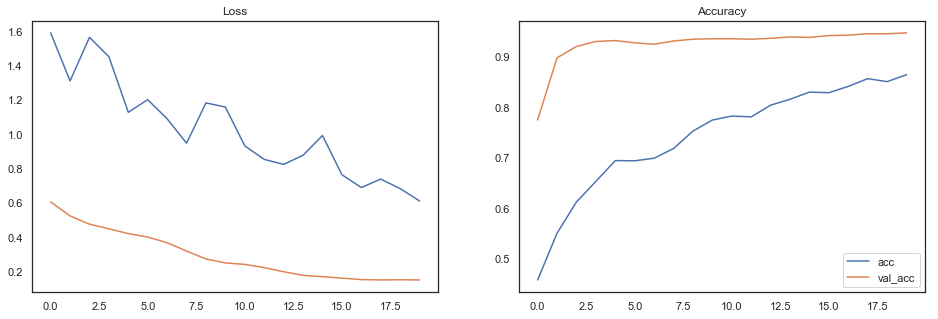

auc: 0.9362800037358737


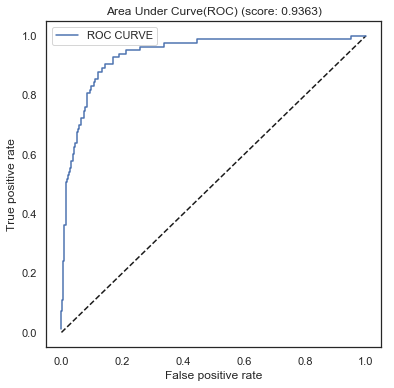

count    1115.000000
mean        0.077714
std         0.186758
min         0.000000
25%         0.000881
50%         0.007364
75%         0.042003
max         0.995855
dtype: float64
0.07771376 0.18675843


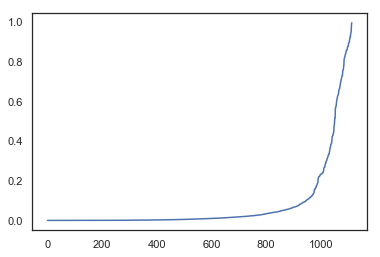

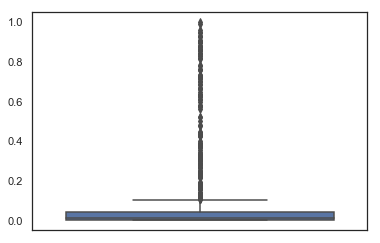

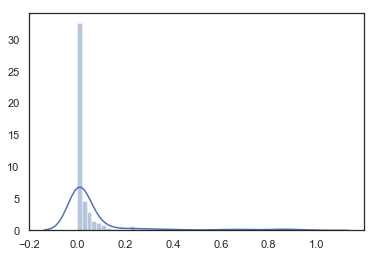

thres: 0.5734, f_beta score: 0.6667
accuracy@0.5734: 0.95

threshold@0.5, accuracy: 0.9462
[[1012   20]
 [  40   43]] 

             precision    recall  f1-score   support

          0       0.96      0.98      0.97      1032
          1       0.72      0.51      0.60        83

avg / total       0.94      0.95      0.94      1115

threshold@0.5734, accuracy: 0.9489
[[1016   16]
 [  41   42]]
             precision    recall  f1-score   support

          0       0.96      0.98      0.97      1032
          1       0.72      0.51      0.60        83

avg / total       0.94      0.95      0.94      1115



f:\anaconda3\envs\py3_6\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [153]:
def get_model(input_dim):
    model = Sequential()
    # kernel_regularizer=regularizers.l2(0.005)
    model.add(Dense(64, activation = 'relu', input_dim = input_dim))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.summary()
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model



K.clear_session()

model = get_model(input_dim=tr_x.shape[1])
hist = model.fit(tr_x, tr_y, 
                 validation_data=(vl_x, vl_y), 
                 batch_size=200,
                 epochs=20,
                 class_weight={0: 1, 1:47},
                 callbacks=[callbacks.ModelCheckpoint('./model_base.h5', 
                                                      save_best_only=True, 
                                                      save_weights_only=True)]) # class_weight={0: 1, 1:204}
model.load_weights('./model_base.h5')

plot_result(hist)
y_pred = model.predict(vl_x)
draw_roc_curve(vl_y, y_pred)

pred_dist(y_pred)
analyze(vl_y, y_pred, .5)

## Observation



## Bining Numeric Feature: 檢查是否要加上Binning的Features

In [26]:
def do_binning(catg_ftrs, status, data, is_train):
    def quartile_binning(x):
        bins = np.percentile(x, range(0, 100, 25))[1:].tolist()
        iqr_x_150 = (bins[-1] - bins[0]) * 1.5
        bins = [bins[0] - iqr_x_150] + bins + [bins[-1] + iqr_x_150]
        result = pd.Series(np.digitize(x, bins)).map(pd.Series([0, 1, 2, 3, 4, 0])).values
        return result, bins
    
    for col in [f'x{i}' for i in range(1, 84) if i != 80]:
        binned_name = f'binn_{col}'
        if is_train:
            result, bins = quartile_binning(data[col])
            status['binn_mapper'][binned_name] = bins
            data[binned_name] = result
        else:
            bins = status['binn_mapper'][binned_name]
            data[binned_name] = pd.Series(np.digitize(data[col], bins))\
                                  .map(pd.Series([0, 1, 2, 3, 4, 0])).values
    
        catg_ftrs.append(binned_name)
    pass

def do_binning(catg_ftrs, status, data, is_train): pass

In [27]:
# Trnasform raw data to foramt model recognized
tr_x, tr_y, status = feature_engineering(raw, is_train=True)
vl_x, vl_y, _ = feature_engineering(raw_vl, is_train=False, status=status)

print( tr_x.shape, vl_x.shape )
tr_x.head()

(2557, 121) (1115, 121)


,x80_1,x80_2,x80_3,x80_4,x80_5,x80_6,x80_7,x80_8,x80_9,x80_10,...,x73,x74,x75,x76,x77,x78,x79,x81,x82,x83
0,0,0,0,0,0,0,0,0,0,0,...,1.281644,0.016187,-0.808312,-0.771575,-0.650523,0.694434,0.276039,-0.305815,2.179313,1.366050
1,0,0,0,0,0,0,0,0,0,0,...,1.281644,1.141300,-0.713097,-0.678267,0.046342,0.694434,0.307733,-0.322732,2.293469,1.441194
2,0,0,0,0,0,0,0,0,0,0,...,1.011921,1.857324,-0.606205,-0.562452,0.046342,0.229868,0.212650,-0.481388,2.407624,1.516338
3,0,0,0,0,0,0,0,0,0,0,...,0.472477,-1.575433,-0.522443,-0.491673,0.162718,0.694434,1.131785,-0.436988,2.521780,1.591482
4,0,0,0,0,0,0,0,0,0,0,...,1.281644,0.016187,-0.808312,-0.771575,-0.650523,0.694434,0.276039,0.099018,-0.446265,-0.287116


## Model (Binning)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                7808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total para

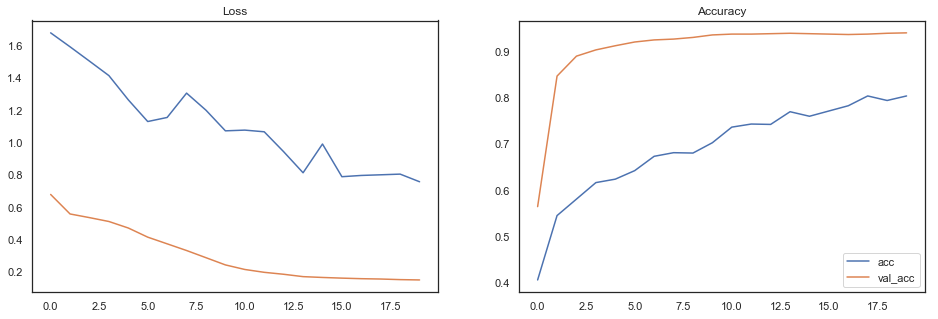

auc: 0.933244606332306


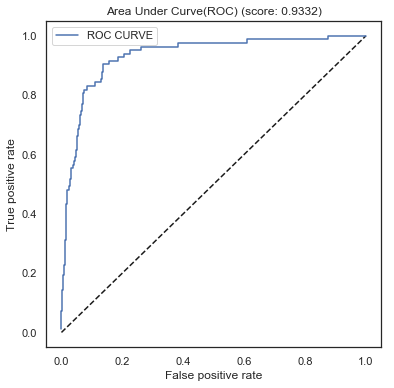

count    1115.000000
mean        0.078244
std         0.172734
min         0.000000
25%         0.000969
50%         0.006944
75%         0.055071
max         0.974306
dtype: float64
0.07824437 0.1727335


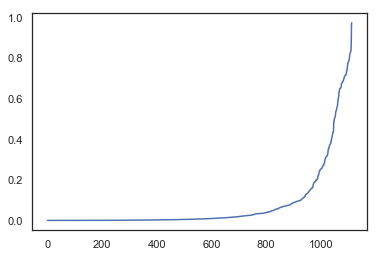

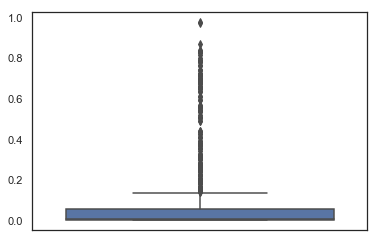

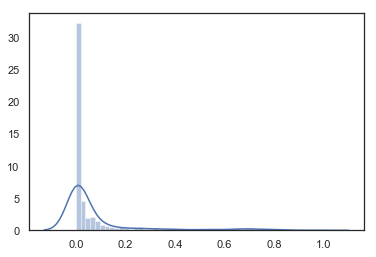

thres: 0.5216, f_beta score: 0.6192
accuracy@0.5216: 0.94

threshold@0.5, accuracy: 0.9390
[[1007   25]
 [  43   40]] 

threshold@0.5216, accuracy: 0.9435
[[1012   20]
 [  43   40]]
             precision    recall  f1-score   support

          0       0.96      0.98      0.97      1032
          1       0.67      0.48      0.56        83

avg / total       0.94      0.94      0.94      1115



f:\anaconda3\envs\py3_6\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [28]:
def get_model(input_dim):
    model = Sequential()
    # kernel_regularizer=regularizers.l2(0.005)
    model.add(Dense(64, activation = 'relu', input_dim = input_dim))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.summary()
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

K.clear_session()

model = get_model(input_dim=tr_x.shape[1])
hist = model.fit(tr_x, tr_y, 
                 validation_data=(vl_x, vl_y), 
                 batch_size=200,
                 epochs=20,
                 class_weight={0: 1, 1:47},
                 callbacks=[callbacks.ModelCheckpoint('./model_base.h5', 
                                                      save_best_only=True, 
                                                      save_weights_only=True)]) # class_weight={0: 1, 1:204}
model.load_weights('./model_base.h5')

plot_result(hist)
y_pred = model.predict(vl_x)
draw_roc_curve(vl_y, y_pred)

pred_dist(y_pred)
analyze(vl_y, y_pred, .5)

## Add Weight of Evidence Encoding: 檢查是否要加上WOE的Features

In [31]:
def do_woe_encoding(catg_ftrs, encoded_ftrs, status, data, is_train):
    def woe_encode(x, label, data):
        """Calculate the Weight of Evidence of given categorical feature and label
    
        :param x: Given feature name
        :param label: Label name
        :param data:
        :return: WOE encoded dictionary
        """
        total_vc = data[label].value_counts().sort_index()
    
        def woe(pipe, total_vc):
            # Count by label in this group
            group_vc = pipe[label].value_counts().sort_index()
    
            # Some class in the feature is missing, fill zero to missing class
            if len(group_vc) < len(total_vc):
                for key in total_vc.index:
                    if key not in group_vc:
                        group_vc[key] = 0.
                group_vc = group_vc.sort_index()
    
            # WOE formula
            r = ((group_vc + 0.5) / total_vc).values
    
            # Odd ratio => 1 to 0, you can define meaning of each class
            return np.log(r[1] / r[0])
    
        return data.groupby(x).apply(lambda pipe: woe(pipe, total_vc))
    
    for catg_col in catg_ftrs:
        if is_train:
            kv = woe_encode(catg_col, 'distress_catg', data)
            status['woe_mapper'][catg_col] = kv.to_dict()
        else:
            kv = pd.Series(status['woe_mapper'][catg_col])
        encoded_ftrs[f'woe_{catg_col}'] = kv.reindex(data[catg_col]).values
    pass

In [32]:
# Trnasform raw data to foramt model recognized
tr_x, tr_y, status = feature_engineering(raw, is_train=True)
vl_x, vl_y, _ = feature_engineering(raw_vl, is_train=False, status=status)

print( tr_x.shape, vl_x.shape )
tr_x.head()

(2557, 122) (1115, 122)


,x80_1,x80_2,x80_3,x80_4,x80_5,x80_6,x80_7,x80_8,x80_9,x80_10,...,x73,x74,x75,x76,x77,x78,x79,x81,x82,x83
0,0,0,0,0,0,0,0,0,0,0,...,1.281644,0.016187,-0.808312,-0.771575,-0.650523,0.694434,0.276039,-0.305815,2.179313,1.366050
1,0,0,0,0,0,0,0,0,0,0,...,1.281644,1.141300,-0.713097,-0.678267,0.046342,0.694434,0.307733,-0.322732,2.293469,1.441194
2,0,0,0,0,0,0,0,0,0,0,...,1.011921,1.857324,-0.606205,-0.562452,0.046342,0.229868,0.212650,-0.481388,2.407624,1.516338
3,0,0,0,0,0,0,0,0,0,0,...,0.472477,-1.575433,-0.522443,-0.491673,0.162718,0.694434,1.131785,-0.436988,2.521780,1.591482
4,0,0,0,0,0,0,0,0,0,0,...,1.281644,0.016187,-0.808312,-0.771575,-0.650523,0.694434,0.276039,0.099018,-0.446265,-0.287116


## Model (WOE)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                7872      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total para

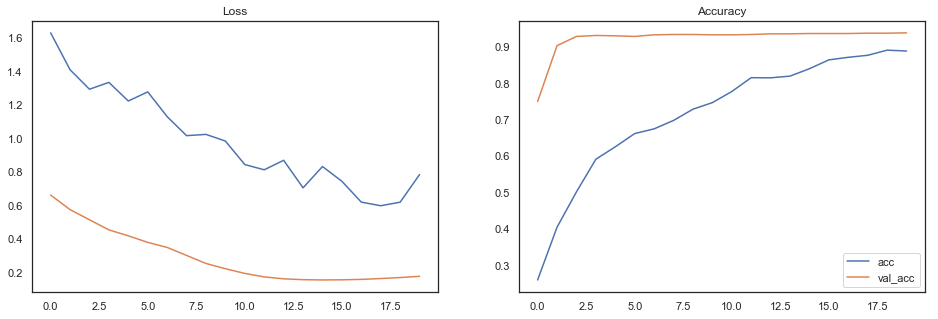

auc: 0.9401676473335201


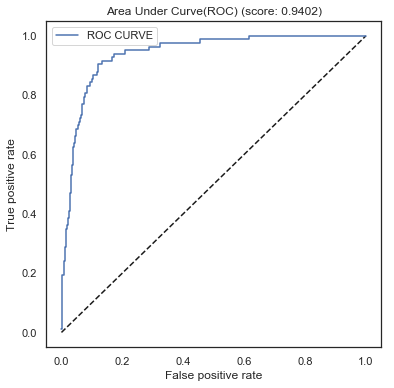

count    1115.000000
mean        0.068237
std         0.157827
min         0.000000
25%         0.003026
50%         0.012336
75%         0.044800
max         0.986661
dtype: float64
0.068236925 0.15782674


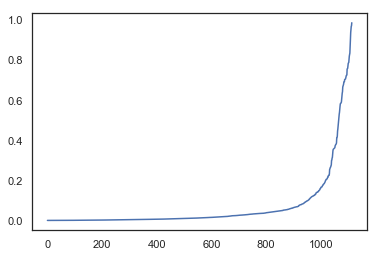

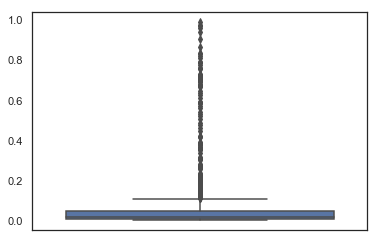

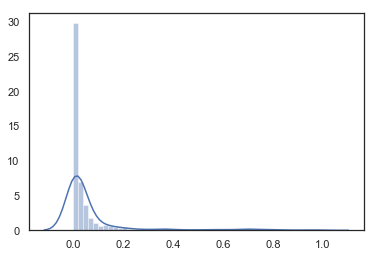

thres: 0.2791, f_beta score: 0.5744
accuracy@0.2791: 0.94

threshold@0.5, accuracy: 0.9354
[[1013   19]
 [  53   30]] 

threshold@0.2791, accuracy: 0.9372
[[1001   31]
 [  39   44]]
             precision    recall  f1-score   support

          0       0.96      0.97      0.97      1032
          1       0.59      0.53      0.56        83

avg / total       0.93      0.94      0.94      1115



f:\anaconda3\envs\py3_6\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [33]:
def get_model(input_dim):
    model = Sequential()
    # kernel_regularizer=regularizers.l2(0.005)
    model.add(Dense(64, activation = 'relu', input_dim = input_dim))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.summary()
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

K.clear_session()
model = get_model(input_dim=tr_x.shape[1])
hist = model.fit(tr_x, tr_y, 
                 validation_data=(vl_x, vl_y), 
                 batch_size=200,
                 epochs=20,
                 class_weight={0: 1, 1:47},
                 callbacks=[callbacks.ModelCheckpoint('./model_base.h5', 
                                                      save_best_only=True, 
                                                      save_weights_only=True)]) # class_weight={0: 1, 1:204}
model.load_weights('./model_base.h5')
plot_result(hist)
y_pred = model.predict(vl_x)
draw_roc_curve(vl_y, y_pred)

pred_dist(y_pred)
analyze(vl_y, y_pred, .5)

## Statistical Encoding, Target Encoding: 檢查是否要加上Target Encoding的Features

* Frequency encoding
* Mean encoding

In [34]:
def do_target_encoding(catg_ftrs, encoded_ftrs, status, data, is_train):
    for catg_col in catg_ftrs:
        if is_train:
            freq_proportion = data[catg_col].value_counts() / len(data)
            encoded_ftrs[f'freq_{catg_col}'] = freq_proportion.reindex(data[catg_col]).values
            target_mean = data.groupby(catg_col).distress_catg.mean()
            encoded_ftrs[f'mean_{catg_col}'] = target_mean.reindex(data[catg_col]).values

            status['freq_mapper'][catg_col] = freq_proportion.to_dict()
            status['mean_mapper'][catg_col] = target_mean.to_dict()
        else:
            encoded_ftrs[f'freq_{catg_col}'] = pd.Series(status['freq_mapper'][catg_col]).reindex(data[catg_col]).values
            encoded_ftrs[f'mean_{catg_col}'] = pd.Series(status['mean_mapper'][catg_col]).reindex(data[catg_col]).values
    pass

In [36]:
# Trnasform raw data to foramt model recognized
tr_x, tr_y, status = feature_engineering(raw, is_train=True)
vl_x, vl_y, _ = feature_engineering(raw_vl, is_train=False, status=status)

tr_x.head()

,x80_1,x80_2,x80_3,x80_4,x80_5,x80_6,x80_7,x80_8,x80_9,x80_10,...,x73,x74,x75,x76,x77,x78,x79,x81,x82,x83
0,0,0,0,0,0,0,0,0,0,0,...,1.281644,0.016187,-0.808312,-0.771575,-0.650523,0.694434,0.276039,-0.305815,2.179313,1.366050
1,0,0,0,0,0,0,0,0,0,0,...,1.281644,1.141300,-0.713097,-0.678267,0.046342,0.694434,0.307733,-0.322732,2.293469,1.441194
2,0,0,0,0,0,0,0,0,0,0,...,1.011921,1.857324,-0.606205,-0.562452,0.046342,0.229868,0.212650,-0.481388,2.407624,1.516338
3,0,0,0,0,0,0,0,0,0,0,...,0.472477,-1.575433,-0.522443,-0.491673,0.162718,0.694434,1.131785,-0.436988,2.521780,1.591482
4,0,0,0,0,0,0,0,0,0,0,...,1.281644,0.016187,-0.808312,-0.771575,-0.650523,0.694434,0.276039,0.099018,-0.446265,-0.287116


## Model (Target Mean Encoding)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                8000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total para

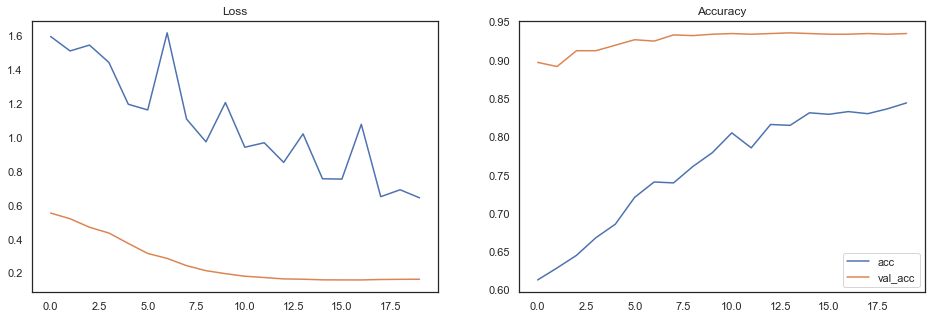

auc: 0.9262164938825068


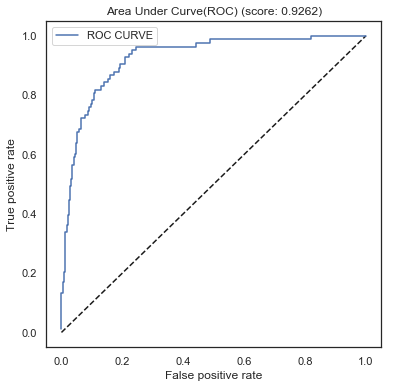

count    1115.000000
mean        0.075348
std         0.167884
min         0.000000
25%         0.000302
50%         0.003250
75%         0.046418
max         0.835601
dtype: float64
0.07534808 0.16788368


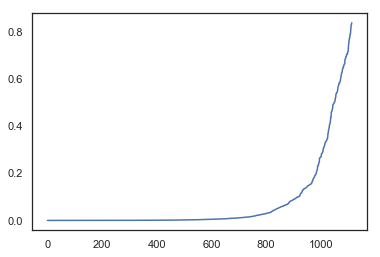

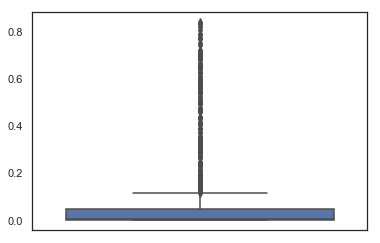

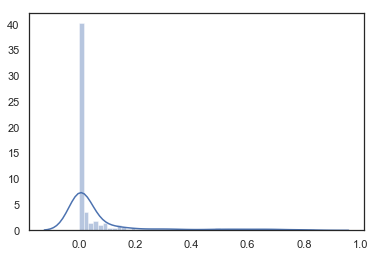

thres: 0.6077, f_beta score: 0.5761
accuracy@0.6077: 0.94

threshold@0.5, accuracy: 0.9336
[[1004   28]
 [  46   37]] 

threshold@0.6077, accuracy: 0.9399
[[1020   12]
 [  55   28]]
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1032
          1       0.70      0.34      0.46        83

avg / total       0.93      0.94      0.93      1115



f:\anaconda3\envs\py3_6\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [39]:
def get_model(input_dim):
    model = Sequential()
    # kernel_regularizer=regularizers.l2(0.005)
    model.add(Dense(64, activation = 'relu', input_dim = input_dim))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.summary()
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

K.clear_session()
model = get_model(input_dim=tr_x.shape[1])
hist = model.fit(tr_x, tr_y, 
                 validation_data=(vl_x, vl_y), 
                 batch_size=200,
                 epochs=20,
                 class_weight={0: 1, 1:47},
                 callbacks=[callbacks.ModelCheckpoint('./model_base.h5', 
                                                      save_best_only=True, 
                                                      save_weights_only=True)]) # class_weight={0: 1, 1:204}
model.load_weights('./model_base.h5')
plot_result(hist)
y_pred = model.predict(vl_x)
draw_roc_curve(vl_y, y_pred)

pred_dist(y_pred)
analyze(vl_y, y_pred, .5)

## Add Polynomial Featue Engineering: 檢查是否要加入多次式

* Add quradratic, cube term base on numeric features

In [61]:
def do_nth_order_polynominal(num_features, data):
#     for num_col in num_features:
#         data[f'{num_col}_degree_2'] = data[num_col] ** 2
#         data[f'{num_col}_degree_3'] = data[num_col] ** 3
    pass

In [86]:
# Trnasform raw data to foramt model recognized
tr_x, tr_y, status = feature_engineering(raw, is_train=True)
vl_x, vl_y, _ = feature_engineering(raw_vl, is_train=False, status=status)

print( tr_x.shape, vl_x.shape )
tr_x.head()

(2557, 124) (1115, 124)


,x80_1,x80_2,x80_3,x80_4,x80_5,x80_6,x80_7,x80_8,x80_9,x80_10,...,x73,x74,x75,x76,x77,x78,x79,x81,x82,x83
0,0,0,0,0,0,0,0,0,0,0,...,1.281644,0.016187,-0.808312,-0.771575,-0.650523,0.694434,0.276039,-0.305815,2.179313,1.366050
1,0,0,0,0,0,0,0,0,0,0,...,1.281644,1.141300,-0.713097,-0.678267,0.046342,0.694434,0.307733,-0.322732,2.293469,1.441194
2,0,0,0,0,0,0,0,0,0,0,...,1.011921,1.857324,-0.606205,-0.562452,0.046342,0.229868,0.212650,-0.481388,2.407624,1.516338
3,0,0,0,0,0,0,0,0,0,0,...,0.472477,-1.575433,-0.522443,-0.491673,0.162718,0.694434,1.131785,-0.436988,2.521780,1.591482
4,0,0,0,0,0,0,0,0,0,0,...,1.281644,0.016187,-0.808312,-0.771575,-0.650523,0.694434,0.276039,0.099018,-0.446265,-0.287116


## Model (Polynominal)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                8000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total para

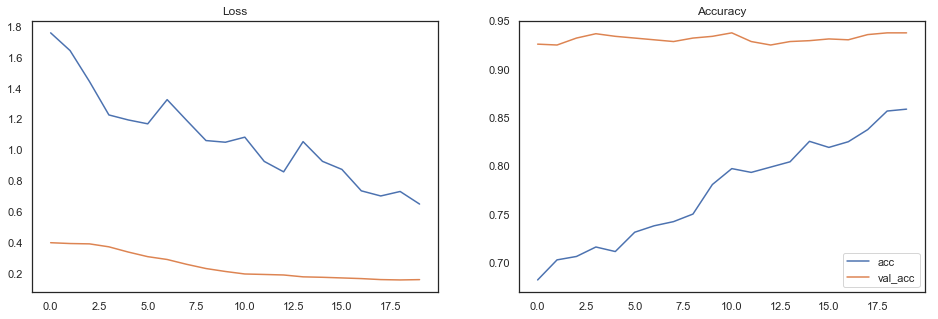

auc: 0.9231460726627441


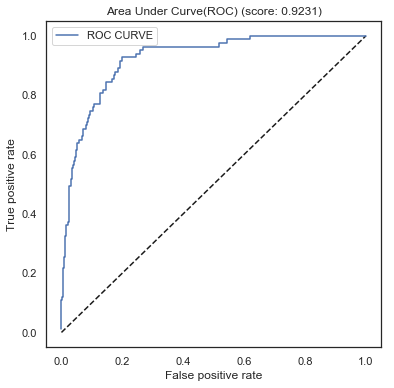

count    1115.000000
mean        0.086592
std         0.179749
min         0.000000
25%         0.000990
50%         0.007503
75%         0.059566
max         0.974540
dtype: float64
0.08659214 0.17974934


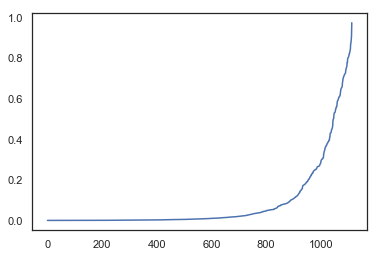

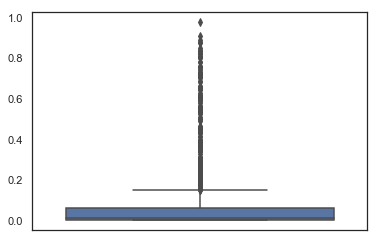

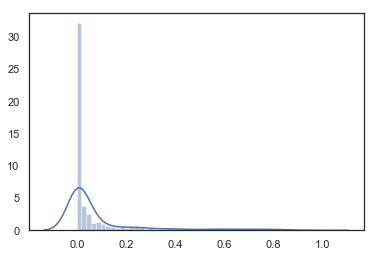

thres: 0.5119, f_beta score: 0.5764
accuracy@0.5119: 0.94

threshold@0.5, accuracy: 0.9372
[[1005   27]
 [  43   40]] 

threshold@0.5119, accuracy: 0.9381
[[1006   26]
 [  43   40]]
             precision    recall  f1-score   support

          0       0.96      0.97      0.97      1032
          1       0.61      0.48      0.54        83

avg / total       0.93      0.94      0.93      1115



f:\anaconda3\envs\py3_6\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [67]:
def get_model(input_dim):
    model = Sequential()
    # kernel_regularizer=regularizers.l2(0.005)
    model.add(Dense(64, activation = 'relu', input_dim = input_dim))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.summary()
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model


K.clear_session()
model = get_model(input_dim=tr_x.shape[1])
hist = model.fit(tr_x, tr_y, 
                 validation_data=(vl_x, vl_y), 
                 batch_size=200,
                 epochs=20,
                 class_weight={0: 1, 1:47},
                 callbacks=[callbacks.ModelCheckpoint('./model_base.h5', 
                                                      save_best_only=True, 
                                                      save_weights_only=True)]) # class_weight={0: 1, 1:204}
model.load_weights('./model_base.h5')
plot_result(hist)
y_pred = model.predict(vl_x)
draw_roc_curve(vl_y, y_pred)

pred_dist(y_pred)
analyze(vl_y, y_pred, .5)

## PCA: 檢測降低維度後Model效果

In [87]:
from sklearn.decomposition import PCA

pca = PCA(n_components=64)
tr_x_pca = pca.fit_transform(tr_x)
vl_x_pca = pca.transform(vl_x)
tr_x_pca.shape, vl_x_pca.shape

((2557, 64), (1115, 64))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total para

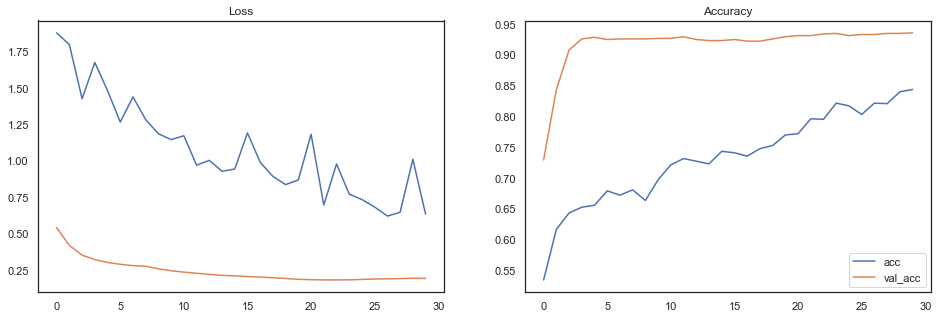

auc: 0.9045951246847856


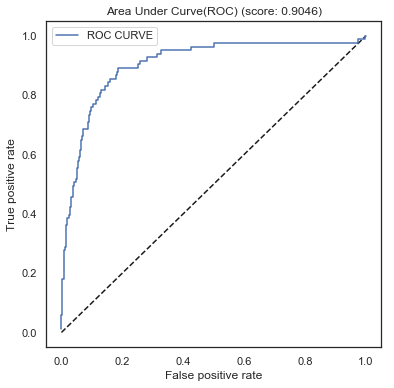

count    1115.000000
mean        0.079087
std         0.172215
min         0.000000
25%         0.001558
50%         0.010152
75%         0.056648
max         0.995415
dtype: float64
0.0790874 0.17221493


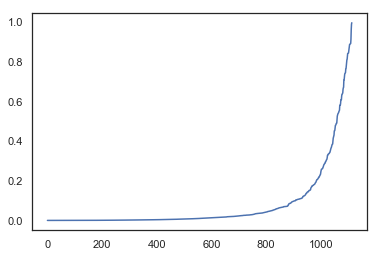

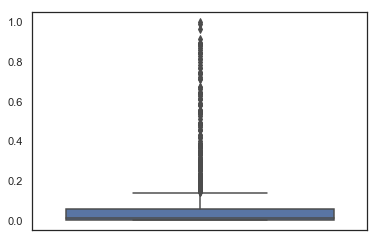

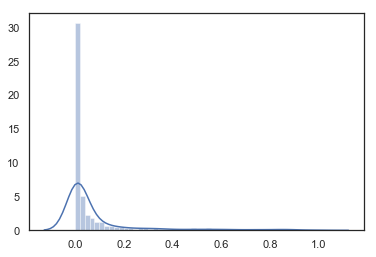

thres: 0.2011, f_beta score: 0.5283
accuracy@0.2011: 0.91

threshold@0.5, accuracy: 0.9336
[[1009   23]
 [  51   32]] 

             precision    recall  f1-score   support

          0       0.97      0.93      0.95      1032
          1       0.43      0.67      0.53        83

avg / total       0.93      0.91      0.92      1115

threshold@0.2011, accuracy: 0.9103
[[959  73]
 [ 27  56]]
             precision    recall  f1-score   support

          0       0.97      0.93      0.95      1032
          1       0.43      0.67      0.53        83

avg / total       0.93      0.91      0.92      1115



f:\anaconda3\envs\py3_6\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [128]:
def get_model(input_dim):
    model = Sequential()
    # kernel_regularizer=regularizers.l2(0.005)
    model.add(Dense(64, activation = 'relu', input_dim = input_dim))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.summary()
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model


K.clear_session()
model = get_model(input_dim=tr_x_pca.shape[1])
hist = model.fit(tr_x_pca, tr_y, 
                 validation_data=(vl_x_pca, vl_y), 
                 batch_size=200,
                 epochs=30,
                 class_weight={0: 1, 1:47},
                 callbacks=[callbacks.ModelCheckpoint('./model_base.h5', 
                                                      save_best_only=True, 
                                                      save_weights_only=True)]) # class_weight={0: 1, 1:204}
model.load_weights('./model_base.h5')
plot_result(hist)
y_pred = model.predict(vl_x_pca)
draw_roc_curve(vl_y, y_pred)

pred_dist(y_pred)
analyze(vl_y, y_pred, 1)

## Model (AutoEncoder)

In [116]:
# Trnasform raw data to foramt model recognized
tr_x, tr_y, status = feature_engineering(raw, is_train=True)
vl_x, vl_y, _ = feature_engineering(raw_vl, is_train=False, status=status)

print( tr_x.shape, vl_x.shape )
tr_x.head()

(2557, 124) (1115, 124)


,x80_1,x80_2,x80_3,x80_4,x80_5,x80_6,x80_7,x80_8,x80_9,x80_10,...,x73,x74,x75,x76,x77,x78,x79,x81,x82,x83
0,0,0,0,0,0,0,0,0,0,0,...,1.281644,0.016187,-0.808312,-0.771575,-0.650523,0.694434,0.276039,-0.305815,2.179313,1.366050
1,0,0,0,0,0,0,0,0,0,0,...,1.281644,1.141300,-0.713097,-0.678267,0.046342,0.694434,0.307733,-0.322732,2.293469,1.441194
2,0,0,0,0,0,0,0,0,0,0,...,1.011921,1.857324,-0.606205,-0.562452,0.046342,0.229868,0.212650,-0.481388,2.407624,1.516338
3,0,0,0,0,0,0,0,0,0,0,...,0.472477,-1.575433,-0.522443,-0.491673,0.162718,0.694434,1.131785,-0.436988,2.521780,1.591482
4,0,0,0,0,0,0,0,0,0,0,...,1.281644,0.016187,-0.808312,-0.771575,-0.650523,0.694434,0.276039,0.099018,-0.446265,-0.287116


Train on 2557 samples, validate on 1115 samples
Epoch 1/200
2557/2557 [==============================] - 0s 110us/step - loss: 1.2893 - val_loss: 9.8733
Epoch 2/200
2557/2557 [==============================] - 0s 22us/step - loss: 0.8360 - val_loss: 8.9409
Epoch 3/200
2557/2557 [==============================] - 0s 21us/step - loss: 0.6283 - val_loss: 8.3418
Epoch 4/200
2557/2557 [==============================] - 0s 21us/step - loss: 0.5143 - val_loss: 8.0385
Epoch 5/200
2557/2557 [==============================] - 0s 21us/step - loss: 0.4458 - val_loss: 7.8570
Epoch 6/200
2557/2557 [==============================] - 0s 21us/step - loss: 0.3926 - val_loss: 7.7303
Epoch 7/200
2557/2557 [==============================] - 0s 22us/step - loss: 0.3508 - val_loss: 7.5678
Epoch 8/200
2557/2557 [==============================] - 0s 22us/step - loss: 0.3092 - val_loss: 7.4577
Epoch 9/200
2557/2557 [==============================] - 0s 23us/step - loss: 0.2782 - val_loss: 7.3324
Epoch 10/200
25

2557/2557 [==============================] - 0s 24us/step - loss: 0.0101 - val_loss: 1.6746
Epoch 156/200
2557/2557 [==============================] - 0s 24us/step - loss: 0.0102 - val_loss: 1.6900
Epoch 157/200
2557/2557 [==============================] - 0s 21us/step - loss: 0.0118 - val_loss: 1.7506
Epoch 158/200
2557/2557 [==============================] - 0s 21us/step - loss: 0.0180 - val_loss: 1.7101
Epoch 159/200
2557/2557 [==============================] - 0s 20us/step - loss: 0.0200 - val_loss: 1.7840
Epoch 160/200
2557/2557 [==============================] - 0s 20us/step - loss: 0.0132 - val_loss: 1.7250
Epoch 161/200
2557/2557 [==============================] - 0s 20us/step - loss: 0.0120 - val_loss: 1.6947
Epoch 162/200
2557/2557 [==============================] - 0s 23us/step - loss: 0.0107 - val_loss: 1.7177
Epoch 163/200
2557/2557 [==============================] - 0s 20us/step - loss: 0.0097 - val_loss: 1.7473
Epoch 164/200
2557/2557 [==============================] - 0

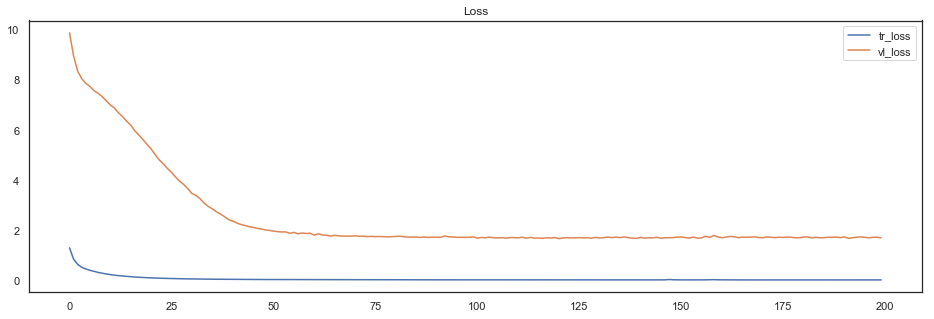

In [142]:
K.clear_session()

inputs_dim = tr_x.shape[1]

inputs = Input(shape=(inputs_dim, ))
# Encoder
encoded = Dense(inputs_dim, activation='selu')(inputs)
encoded = Dense(64, activation='selu')(encoded)

# Decoder
decoded = Dense(inputs_dim, activation='linear')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(inputs, decoded)

# this model maps an input to its encoded representation
encoder = Model(inputs, encoded)

# Adam Optimizer + Mean square error loss
autoencoder.compile(optimizer='adam', loss='mse')
hist = autoencoder.fit(
            tr_x, tr_x, 
            epochs=200, 
            batch_size=200, 
            shuffle=True, 
            validation_data=(vl_x, vl_x))

def plot_ae(hist):
    plt.figure(figsize=(16, 5))
    plt.plot(hist.history['loss'], label='tr_loss')
    plt.plot(hist.history['val_loss'], label='vl_loss')
    plt.title('Loss')
    plt.legend(loc='best')
    plt.show()
    
plot_ae(hist)

In [143]:
tr_x_ae = encoder.predict(tr_x)
vl_x_ae = encoder.predict(vl_x)
tr_x_ae.shape, vl_x_ae.shape

((2557, 64), (1115, 64))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total para

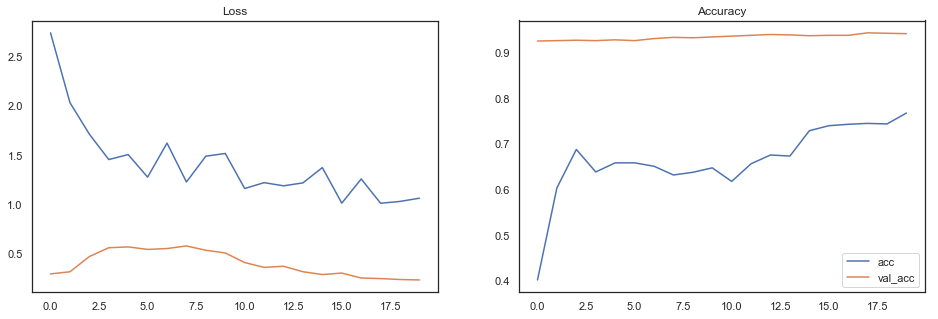

auc: 0.9291001214158962


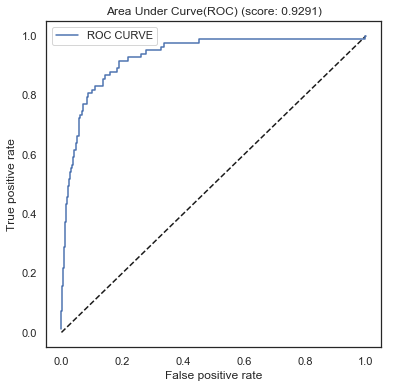

count    1.115000e+03
mean     1.650792e-01
std      1.319812e-01
min      4.155501e-18
25%      7.621213e-02
50%      1.251567e-01
75%      2.033093e-01
max      8.648074e-01
dtype: float64
0.16507919 0.13198118


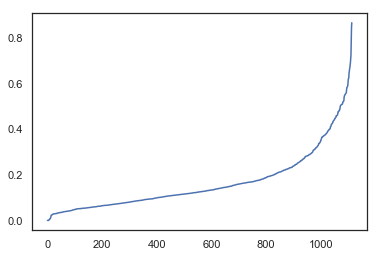

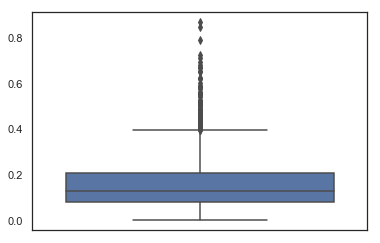

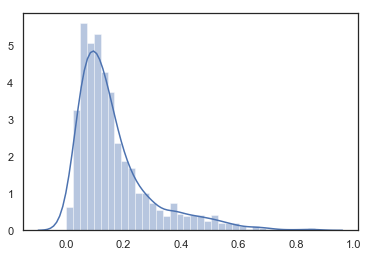

thres: 0.3319, f_beta score: 0.5854
accuracy@0.3319: 0.92

threshold@0.5, accuracy: 0.9408
[[1019   13]
 [  53   30]] 

             precision    recall  f1-score   support

          0       0.98      0.94      0.96      1032
          1       0.49      0.72      0.59        83

avg / total       0.94      0.92      0.93      1115

threshold@0.3319, accuracy: 0.9238
[[970  62]
 [ 23  60]]
             precision    recall  f1-score   support

          0       0.98      0.94      0.96      1032
          1       0.49      0.72      0.59        83

avg / total       0.94      0.92      0.93      1115



f:\anaconda3\envs\py3_6\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [145]:
def get_model(input_dim):
    model = Sequential()
    # kernel_regularizer=regularizers.l2(0.005)
    model.add(Dense(64, activation = 'relu', input_dim = input_dim))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.summary()
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

K.clear_session()
model = get_model(input_dim=tr_x_ae.shape[1])
hist = model.fit(tr_x_ae, tr_y, 
                 validation_data=(vl_x_ae, vl_y), 
                 batch_size=200,
                 epochs=20,
                 class_weight={0: 1, 1:47},
                 callbacks=[callbacks.ModelCheckpoint('./model_base.h5', 
                                                      save_best_only=True, 
                                                      save_weights_only=True)]) # class_weight={0: 1, 1:204}
model.load_weights('./model_base.h5')
plot_result(hist)
y_pred = model.predict(vl_x_ae)
draw_roc_curve(vl_y, y_pred)

pred_dist(y_pred)
analyze(vl_y, y_pred, 1)